# Визуализация и отчётность (Jupyter)

Этот ноутбук строит простые и таблицы по витринам DBT (схема `analytics`) и формулирует короткие.


In [ ]:
import os

import pandas as pd
import sqlalchemy as sa


def env(name: str, default: str) -> str:
    return os.getenv(name, default)


POSTGRES_HOST = env("POSTGRES_HOST", "213.171.31.111")
POSTGRES_PORT = int(env("POSTGRES_PORT", "5433"))
POSTGRES_DB = env("POSTGRES_DB", "blockchain")
POSTGRES_USER = env("POSTGRES_USER", "postgres")
POSTGRES_PASSWORD = env("POSTGRES_PASSWORD", "postgres")

engine = sa.create_engine(
    f"postgresql+psycopg2://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
)

PREFERRED_SCHEMAS: list[str] = ["public_analytics", "analytics"]


def find_table_schema(table_name: str) -> list[str]:
    """Return schemas where table exists."""
    q = sa.text(
        """
        select table_schema
        from information_schema.tables
        where table_name = :table_name
        order by table_schema
        """
    )
    with engine.connect() as conn:
        rows = conn.execute(q, {"table_name": table_name}).fetchall()
    return [r[0] for r in rows]


def resolve_table(table_name: str, preferred_schemas: list[str] | None = None) -> str:
    schemas = find_table_schema(table_name)
    if not schemas:
        raise RuntimeError(f"Table not found: {table_name}")

    preferred_schemas = preferred_schemas or []
    for s in preferred_schemas:
        if s in schemas:
            return f"{s}.{table_name}"

    return f"{schemas[0]}.{table_name}"


def read_sql(query: str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql(sa.text(query), conn)


DAILY_TBL = resolve_table("daily_transaction_summary", PREFERRED_SCHEMAS)
WALLET_FACT_TBL = resolve_table("fct_wallet_activity", PREFERRED_SCHEMAS)
WALLET_DIM_TBL = resolve_table("dim_wallets", PREFERRED_SCHEMAS)

DAILY_TBL, WALLET_FACT_TBL, WALLET_DIM_TBL


('public_analytics.daily_transaction_summary',
 'public_analytics.fct_wallet_activity',
 'public_analytics.dim_wallets')

In [18]:
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public'
ORDER BY table_name;
"""
public_tables = read_sql(query)
print(public_tables)

      table_name
0  overall_stats
1   transactions
2   wallet_stats
3        wallets


In [20]:
query = """
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema NOT IN ('pg_catalog', 'information_schema')
ORDER BY table_schema, table_name;
"""
tables = read_sql(query)
print(tables)

           table_schema                     table_name
0                public                  overall_stats
1                public                   transactions
2                public                   wallet_stats
3                public                        wallets
4      public_analytics      daily_transaction_summary
5      public_analytics                    dim_wallets
6      public_analytics            fct_wallet_activity
7            public_edr       alerts_anomaly_detection
8            public_edr              alerts_dbt_models
9            public_edr    alerts_dbt_source_freshness
10           public_edr               alerts_dbt_tests
11           public_edr          alerts_schema_changes
12           public_edr  anomaly_threshold_sensitivity
13           public_edr        data_monitoring_metrics
14           public_edr           dbt_artifacts_hashes
15           public_edr                    dbt_columns
16           public_edr                  dbt_exposures
17        

In [21]:
# Проверим структуру таблиц
transactions_info = read_sql("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_schema = 'public' AND table_name = 'transactions'
    ORDER BY ordinal_position
""")
print("Transactions columns:")
print(transactions_info)

wallets_info = read_sql("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_schema = 'public' AND table_name = 'wallets'
    ORDER BY ordinal_position
""")
print("\nWallets columns:")
print(wallets_info)

Transactions columns:
       column_name                    data_type
0               id                      integer
1             hash            character varying
2   wallet_address            character varying
3     from_address            character varying
4       to_address            character varying
5        value_eth                      numeric
6         gas_used                       bigint
7        gas_price                       bigint
8     block_number                       bigint
9         is_error                      boolean
10       timestamp  timestamp without time zone
11       loaded_at  timestamp without time zone

Wallets columns:
         column_name                    data_type
0                 id                      integer
1            address            character varying
2  transaction_count                      integer
3           added_at  timestamp without time zone
4       last_updated  timestamp without time zone
5          loaded_at  timestamp with

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

daily = read_sql(
    f"""
    select
        transaction_date,
        transaction_count,
        unique_wallets,
        total_volume_eth,
        failure_rate_pct,
        avg_transaction_value_eth,
        failed_transactions,
        successful_transactions
    from {DAILY_TBL}
    order by transaction_date
    """
)

daily["transaction_date"] = pd.to_datetime(daily["transaction_date"])
daily.tail(5)


,transaction_date,transaction_count,unique_wallets,total_volume_eth,failure_rate_pct,avg_transaction_value_eth,failed_transactions,successful_transactions
0,2025-12-11,8244,3,100083.585891,0.0,12.140173,0,8244
1,2025-12-12,8506,3,69729.998948,0.0,8.197743,0,8506


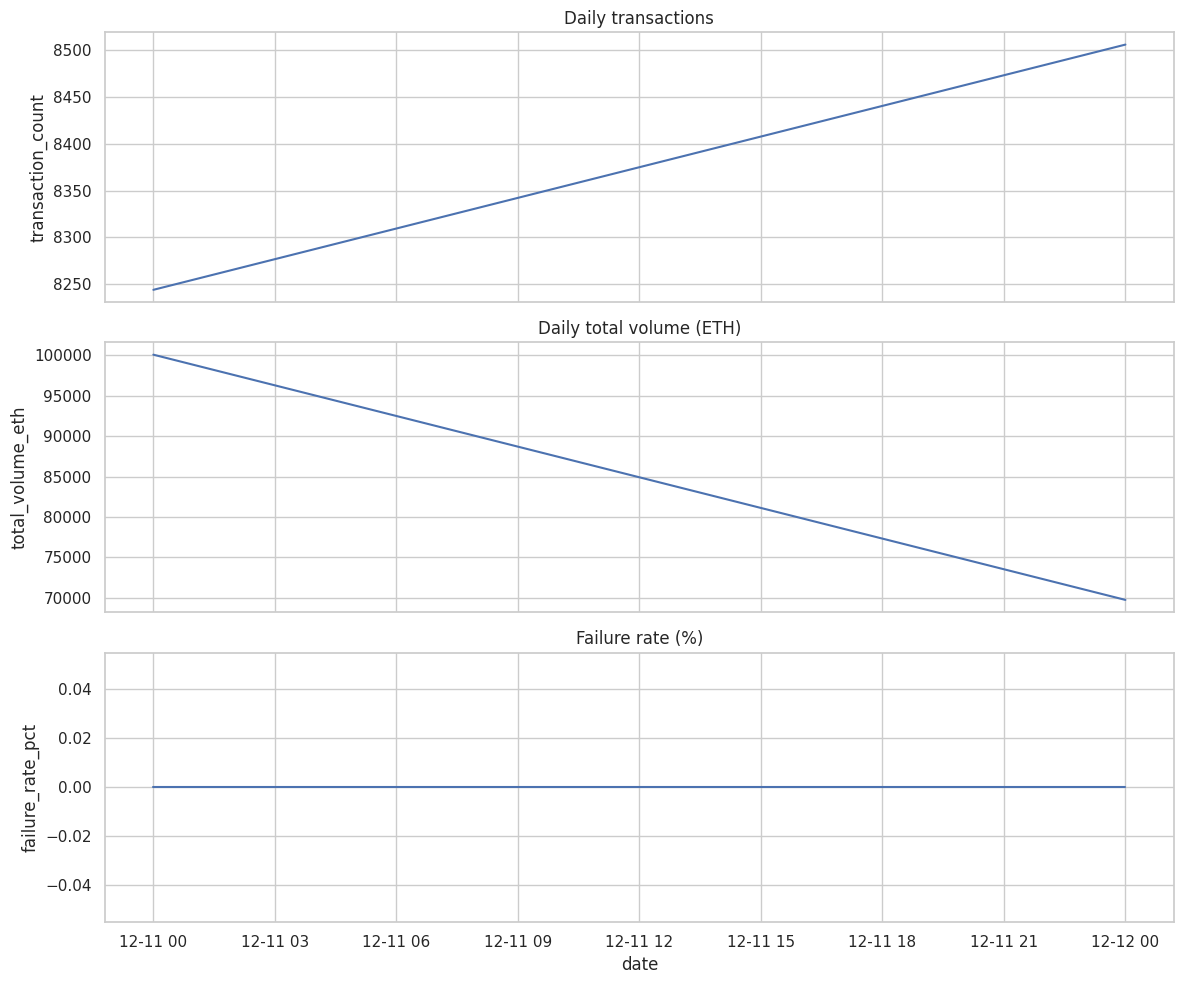

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=daily, x="transaction_date", y="transaction_count", ax=ax[0])
ax[0].set_title("Daily transactions")

sns.lineplot(data=daily, x="transaction_date", y="total_volume_eth", ax=ax[1])
ax[1].set_title("Daily total volume (ETH)")

sns.lineplot(data=daily, x="transaction_date", y="failure_rate_pct", ax=ax[2])
ax[2].set_title("Failure rate (%)")
ax[2].set_xlabel("date")

plt.tight_layout()
plt.show()

# A few quick numeric insights
if len(daily) > 0:
    last_14 = daily.tail(14)
    insight = {
        "days_covered": int((daily["transaction_date"].max() - daily["transaction_date"].min()).days) + 1,
        "last_day_tx": int(daily.iloc[-1]["transaction_count"]),
        "last_day_volume_eth": float(daily.iloc[-1]["total_volume_eth"]),
        "avg_failure_rate_last_14d_pct": float(last_14["failure_rate_pct"].mean()),
    }
    insight


In [22]:
# Почасовая агрегация за последние 30 дней
hourly = read_sql("""
    SELECT
        DATE_TRUNC('hour', timestamp) as hour,
        COUNT(*) as tx_count,
        COUNT(DISTINCT wallet_address) as unique_wallets,
        COUNT(DISTINCT from_address) as unique_senders,
        COUNT(DISTINCT to_address) as unique_receivers,
        SUM(value_eth) as volume_eth,
        AVG(value_eth) as avg_value_eth,
        SUM(CASE WHEN is_error = true THEN 1 ELSE 0 END) as failed_tx,
        AVG(gas_used) as avg_gas_used,
        AVG(gas_price) as avg_gas_price
    FROM public.transactions
    WHERE timestamp >= NOW() - INTERVAL '30 days'
    GROUP BY DATE_TRUNC('hour', timestamp)
    ORDER BY hour
""")

hourly['hour'] = pd.to_datetime(hourly['hour'])
hourly['failure_rate'] = (hourly['failed_tx'] / hourly['tx_count'] * 100).fillna(0)

print(f"Hourly data: {len(hourly)} hours")
hourly.tail()

Hourly data: 19 hours


,hour,tx_count,unique_wallets,unique_senders,unique_receivers,volume_eth,avg_value_eth,failed_tx,avg_gas_used,avg_gas_price,failure_rate
14,2025-12-12 06:00:00,876,3,59,224,6625.983802,7.563908,0,50903.594749,1.148368e+08,0.0
15,2025-12-12 07:00:00,798,3,63,215,5589.987910,7.004997,0,49889.547619,1.152642e+08,0.0
16,2025-12-12 10:00:00,695,3,24,213,1114.505541,1.603605,0,54478.857554,1.008207e+08,0.0
17,2025-12-12 11:00:00,1223,3,46,336,18142.175094,14.834158,0,54577.933769,1.006073e+08,0.0
18,2025-12-12 12:00:00,816,3,45,228,4690.123128,5.747700,0,54004.230392,1.060706e+08,0.0


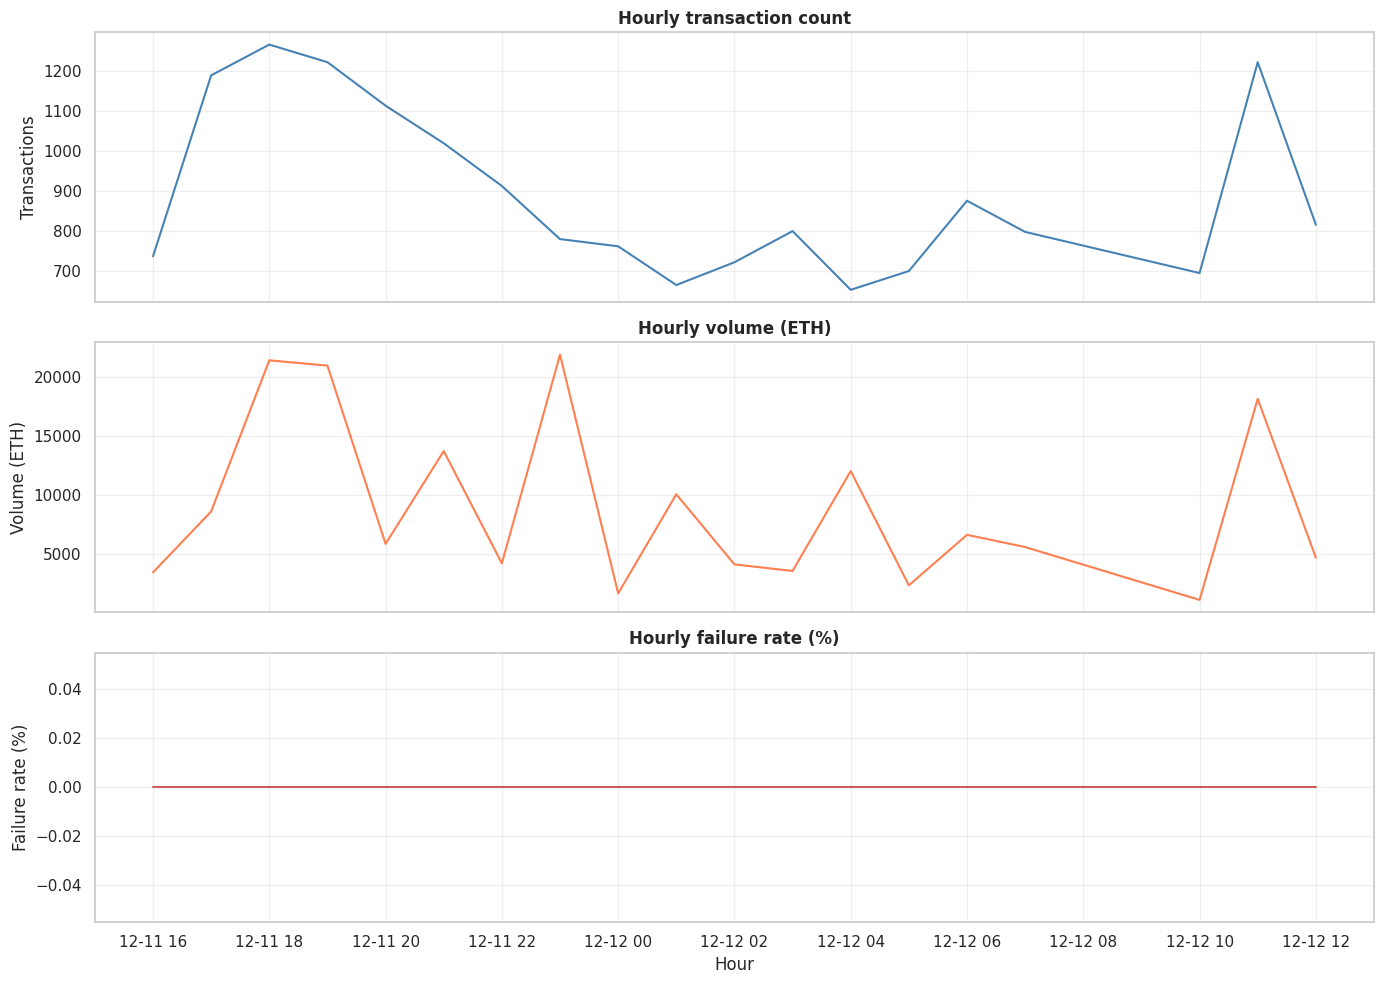

In [23]:
# Визуализация почасовых трендов
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

ax[0].plot(hourly['hour'], hourly['tx_count'], color='steelblue', linewidth=1.5)
ax[0].set_title('Hourly transaction count', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Transactions')
ax[0].grid(True, alpha=0.3)

ax[1].plot(hourly['hour'], hourly['volume_eth'], color='coral', linewidth=1.5)
ax[1].set_title('Hourly volume (ETH)', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Volume (ETH)')
ax[1].grid(True, alpha=0.3)

ax[2].plot(hourly['hour'], hourly['failure_rate'], color='indianred', linewidth=1.5)
ax[2].set_title('Hourly failure rate (%)', fontsize=12, fontweight='bold')
ax[2].set_ylabel('Failure rate (%)')
ax[2].set_xlabel('Hour')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

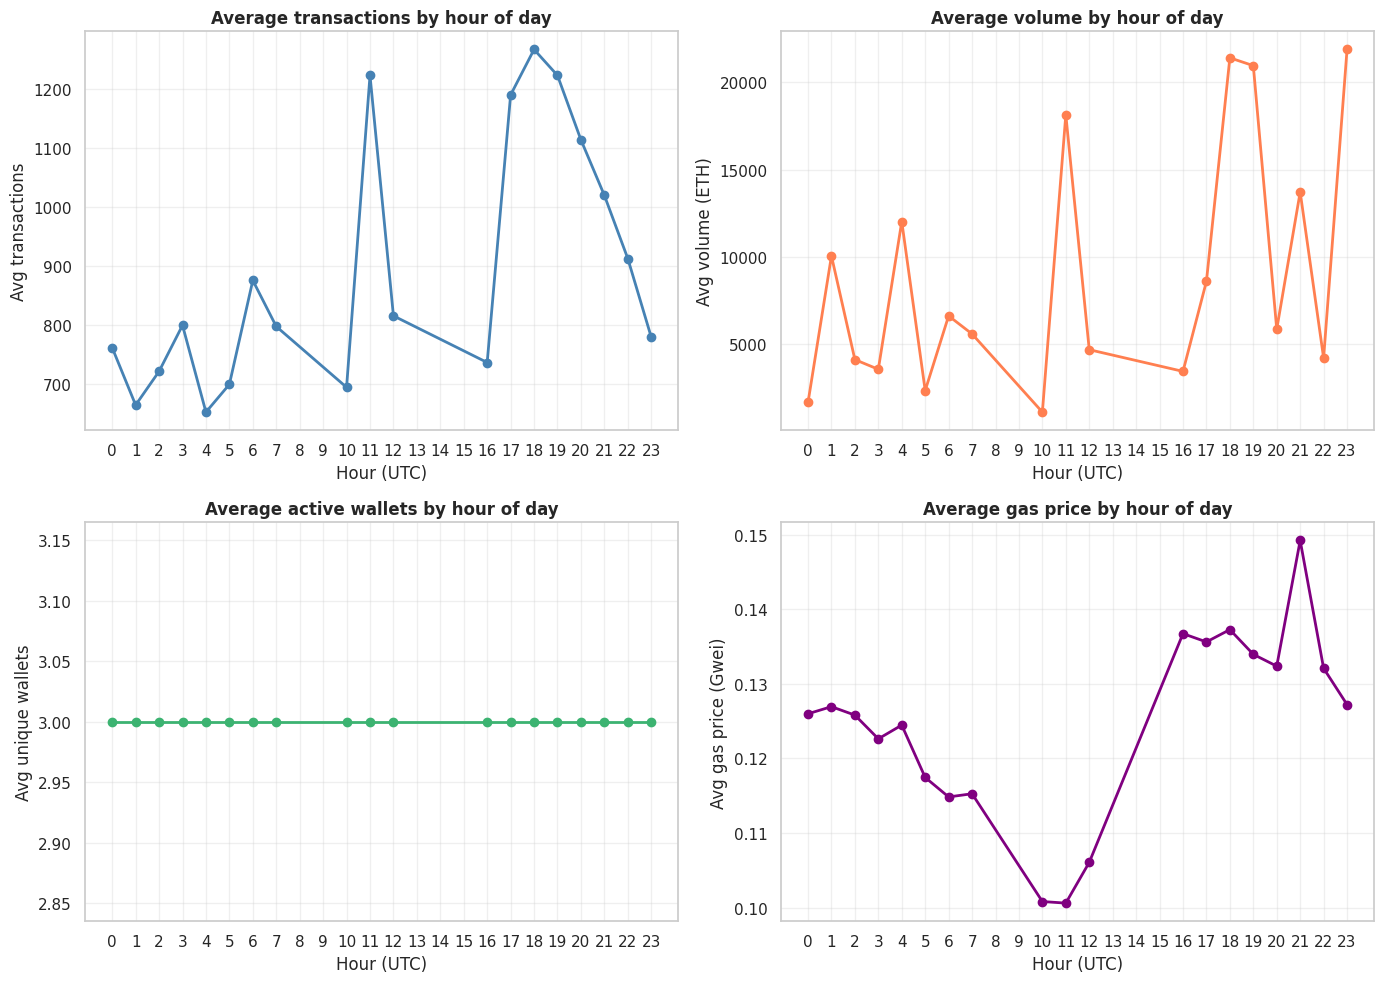


🔥 Peak hour: 18:00 UTC
   Avg transactions: 1267
   Avg volume: 21404.53 ETH


In [24]:
# Средняя активность по часам суток (агрегация по всем дням)
hourly['hour_of_day'] = hourly['hour'].dt.hour
hourly['day_of_week'] = hourly['hour'].dt.day_name()

hourly_pattern = hourly.groupby('hour_of_day').agg({
    'tx_count': 'mean',
    'volume_eth': 'mean',
    'unique_wallets': 'mean',
    'failure_rate': 'mean',
    'avg_gas_price': 'mean'
}).reset_index()

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Transactions by hour
ax[0, 0].plot(hourly_pattern['hour_of_day'], hourly_pattern['tx_count'],
              marker='o', linewidth=2, markersize=6, color='steelblue')
ax[0, 0].set_title('Average transactions by hour of day', fontweight='bold')
ax[0, 0].set_xlabel('Hour (UTC)')
ax[0, 0].set_ylabel('Avg transactions')
ax[0, 0].set_xticks(range(0, 24))
ax[0, 0].grid(True, alpha=0.3)

# Volume by hour
ax[0, 1].plot(hourly_pattern['hour_of_day'], hourly_pattern['volume_eth'],
              marker='o', linewidth=2, markersize=6, color='coral')
ax[0, 1].set_title('Average volume by hour of day', fontweight='bold')
ax[0, 1].set_xlabel('Hour (UTC)')
ax[0, 1].set_ylabel('Avg volume (ETH)')
ax[0, 1].set_xticks(range(0, 24))
ax[0, 1].grid(True, alpha=0.3)

# Active wallets by hour
ax[1, 0].plot(hourly_pattern['hour_of_day'], hourly_pattern['unique_wallets'],
              marker='o', linewidth=2, markersize=6, color='mediumseagreen')
ax[1, 0].set_title('Average active wallets by hour of day', fontweight='bold')
ax[1, 0].set_xlabel('Hour (UTC)')
ax[1, 0].set_ylabel('Avg unique wallets')
ax[1, 0].set_xticks(range(0, 24))
ax[1, 0].grid(True, alpha=0.3)

# Gas price by hour
ax[1, 1].plot(hourly_pattern['hour_of_day'], hourly_pattern['avg_gas_price'] / 1e9,
              marker='o', linewidth=2, markersize=6, color='purple')
ax[1, 1].set_title('Average gas price by hour of day', fontweight='bold')
ax[1, 1].set_xlabel('Hour (UTC)')
ax[1, 1].set_ylabel('Avg gas price (Gwei)')
ax[1, 1].set_xticks(range(0, 24))
ax[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Найти пиковый час
peak_hour = hourly_pattern.loc[hourly_pattern['tx_count'].idxmax()]
print(f"\n🔥 Peak hour: {int(peak_hour['hour_of_day'])}:00 UTC")
print(f"   Avg transactions: {peak_hour['tx_count']:.0f}")
print(f"   Avg volume: {peak_hour['volume_eth']:.2f} ETH")

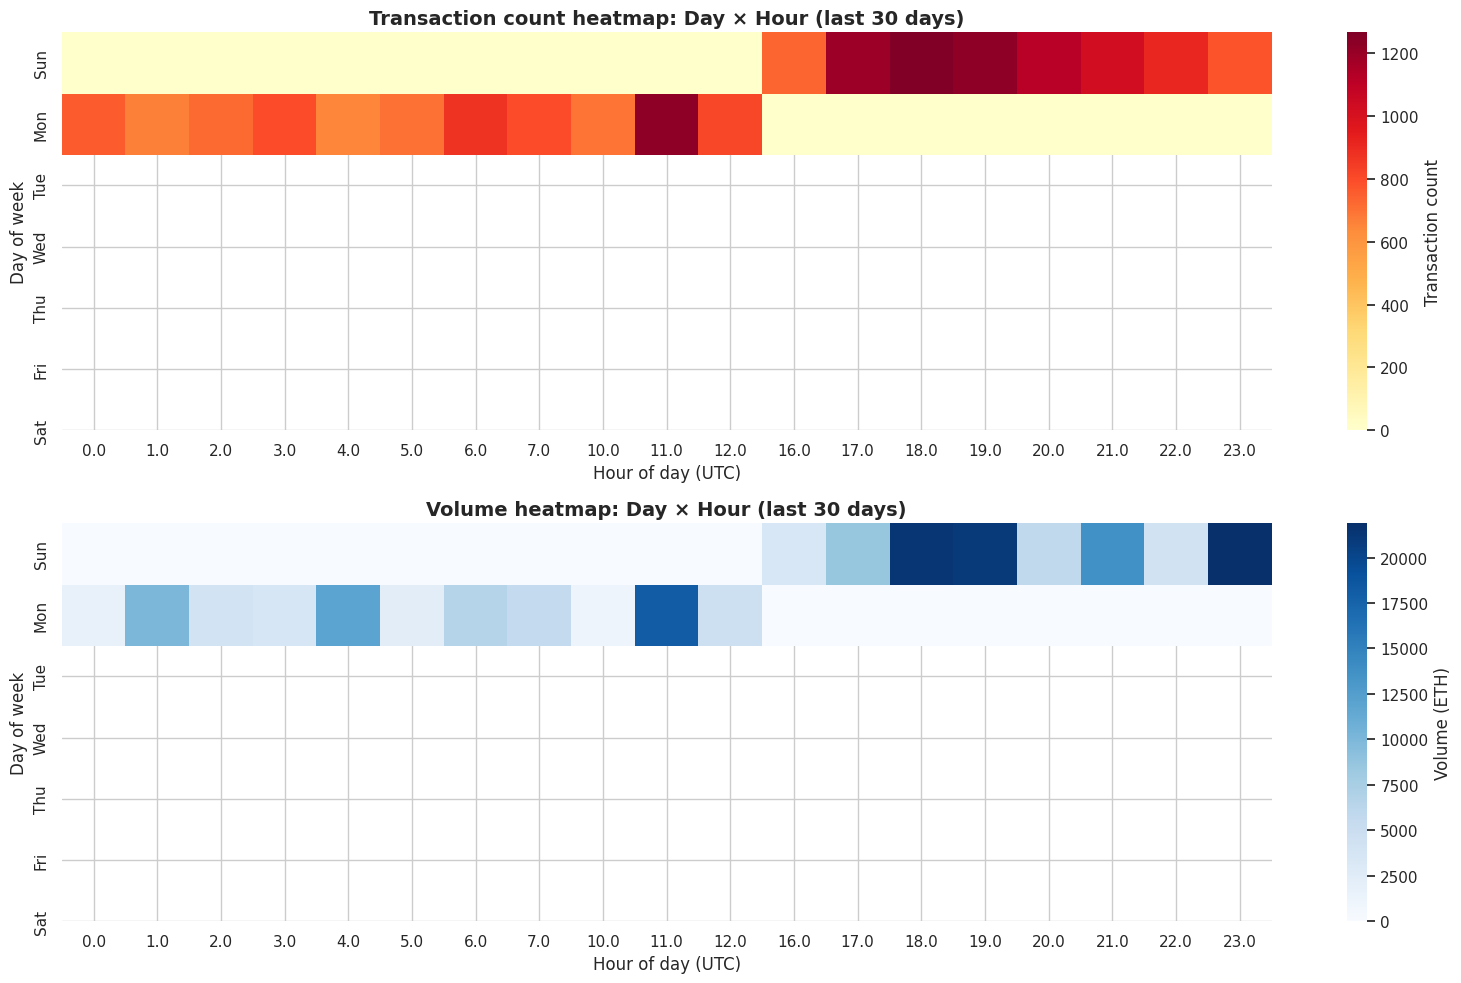


🔥 Peak activity:
   Day: Thu
   Hour: 18:00 UTC
   Transactions: 1267


In [25]:
# Данные для тепловой карты
heatmap_data = read_sql("""
    SELECT
        EXTRACT(DOW FROM timestamp) as day_of_week,
        EXTRACT(HOUR FROM timestamp) as hour,
        COUNT(*) as tx_count,
        SUM(value_eth) as volume_eth
    FROM public.transactions
    WHERE timestamp >= NOW() - INTERVAL '30 days'
    GROUP BY day_of_week, hour
""")

# Pivot для транзакций
heatmap_tx = heatmap_data.pivot(index='day_of_week', columns='hour', values='tx_count').fillna(0)
heatmap_vol = heatmap_data.pivot(index='day_of_week', columns='hour', values='volume_eth').fillna(0)

days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig, ax = plt.subplots(2, 1, figsize=(16, 10))

# Heatmap транзакций
sns.heatmap(heatmap_tx, cmap='YlOrRd', annot=False, fmt='g',
            yticklabels=days, cbar_kws={'label': 'Transaction count'}, ax=ax[0])
ax[0].set_title('Transaction count heatmap: Day × Hour (last 30 days)',
                fontsize=14, fontweight='bold')
ax[0].set_xlabel('Hour of day (UTC)')
ax[0].set_ylabel('Day of week')

# Heatmap объема
sns.heatmap(heatmap_vol, cmap='Blues', annot=False, fmt='g',
            yticklabels=days, cbar_kws={'label': 'Volume (ETH)'}, ax=ax[1])
ax[1].set_title('Volume heatmap: Day × Hour (last 30 days)',
                fontsize=14, fontweight='bold')
ax[1].set_xlabel('Hour of day (UTC)')
ax[1].set_ylabel('Day of week')

plt.tight_layout()
plt.show()

# Находим самый активный момент
max_tx_idx = heatmap_data['tx_count'].idxmax()
peak_moment = heatmap_data.loc[max_tx_idx]
print(f"\n🔥 Peak activity:")
print(f"   Day: {days[int(peak_moment['day_of_week'])]}")
print(f"   Hour: {int(peak_moment['hour'])}:00 UTC")
print(f"   Transactions: {int(peak_moment['tx_count'])}")


WALLET SEGMENTATION ANALYSIS
       segment  wallet_address_count  total_volume_eth_sum  total_volume_eth_mean  total_volume_eth_median  actual_tx_count_mean  actual_tx_count_median  net_balance_eth_mean  net_balance_eth_median
       🐋 Whale                     1             124891.42              124891.42                124891.42                7876.0                  7876.0             -14906.70               -14906.70
👤 Regular User                     2              44922.17               22461.08                 22461.08                4437.0                  4437.0              -5324.96                -5324.96


/tmp/ipython-input-925565056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_stats, x='segment', y='wallet_address_count',
/tmp/ipython-input-925565056.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_stats, x='segment', y='total_volume_eth_sum',
/tmp/ipython-input-925565056.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_stats, x='segment', y='total_volume_eth_mean',
/tmp/ipython-input-925565056.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be re

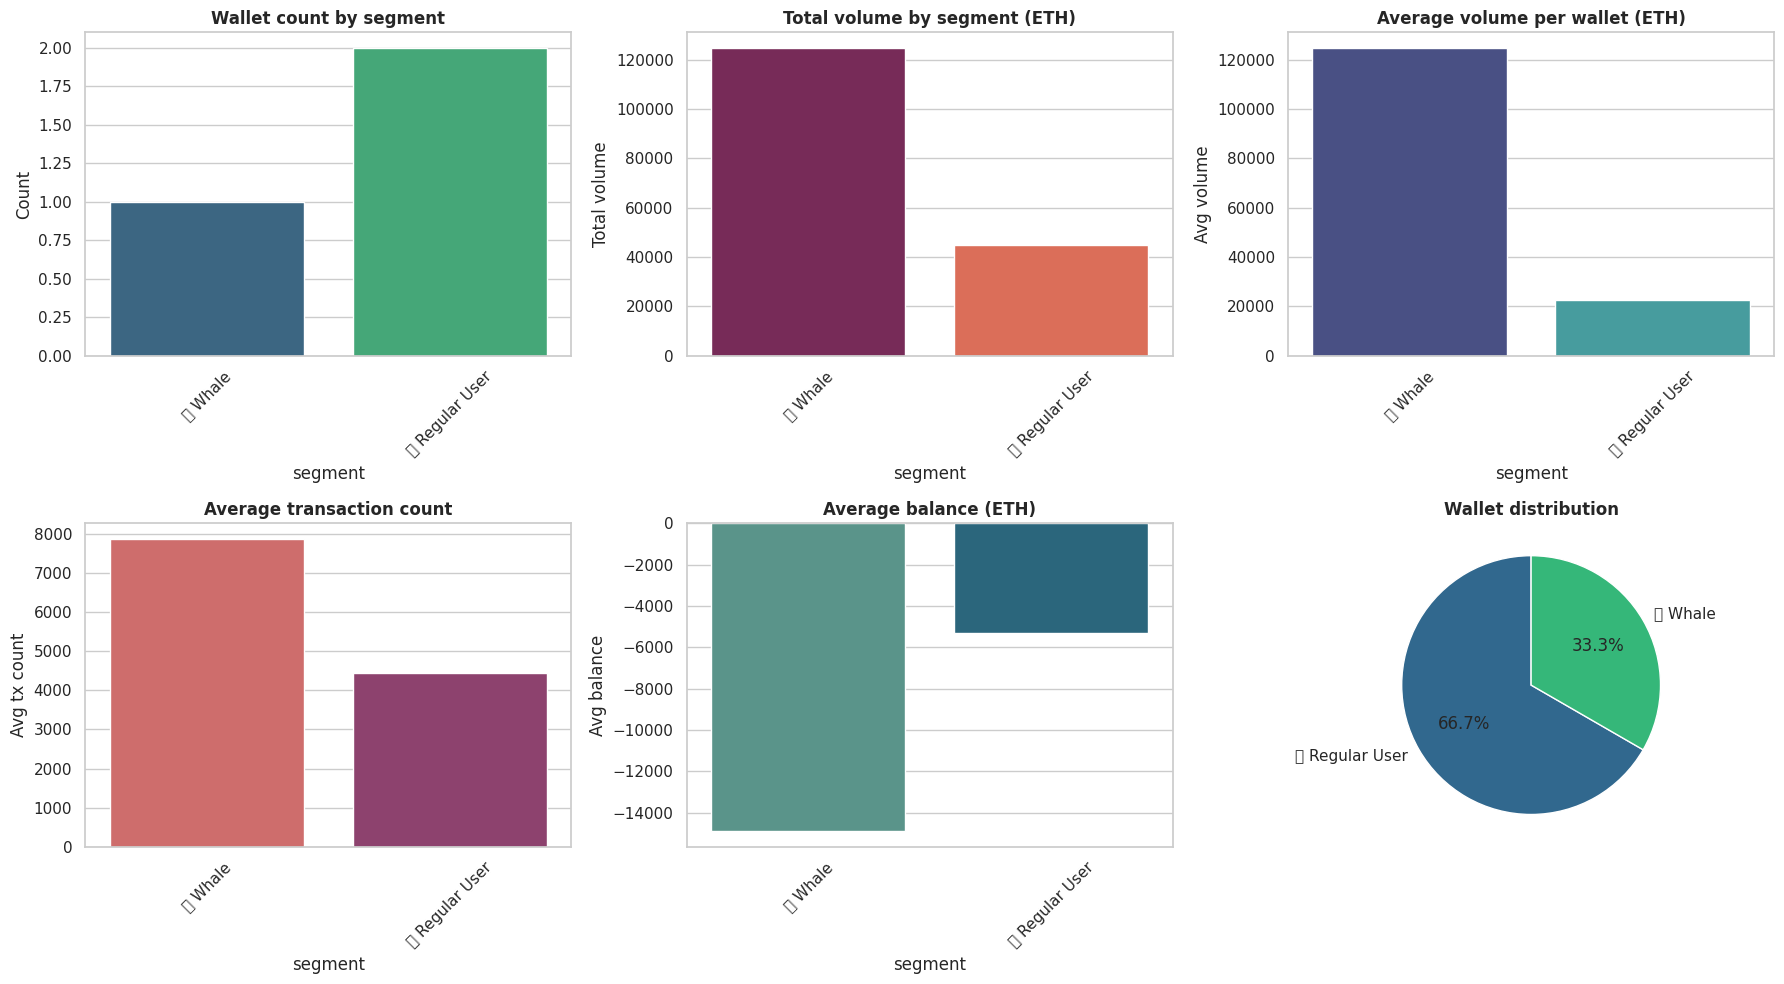

In [ ]:
# Используем уже загруженные данные wallets
def segment_wallet(row):
    vol_90 = wallets['total_volume_eth'].quantile(0.9)
    vol_50 = wallets['total_volume_eth'].quantile(0.5)
    tx_75 = wallets['actual_tx_count'].quantile(0.75)
    tx_25 = wallets['actual_tx_count'].quantile(0.25)

    if row['total_volume_eth'] > vol_90:
        return 'Whale'
    elif row['total_volume_eth'] > vol_50 and row['actual_tx_count'] > tx_75:
        return 'Active Trader'
    elif row['actual_tx_count'] > tx_75:
        return 'High Frequency'
    elif row['actual_tx_count'] < tx_25 and row['total_volume_eth'] < vol_50:
        return 'Low Activity'
    elif row['actual_tx_count'] == 0:
        return 'Inactive'
    else:
        return 'Regular User'

wallets['segment'] = wallets.apply(segment_wallet, axis=1)

# Статистика по сегментам
segment_stats = wallets.groupby('segment').agg({
    'wallet_address': 'count',
    'total_volume_eth': ['sum', 'mean', 'median'],
    'actual_tx_count': ['mean', 'median'],
    'net_balance_eth': ['mean', 'median']
}).round(2)

segment_stats.columns = ['_'.join(col).strip() for col in segment_stats.columns.values]
segment_stats = segment_stats.reset_index()
segment_stats = segment_stats.sort_values('total_volume_eth_sum', ascending=False)

print("\n" + "="*80)
print("WALLET SEGMENTATION ANALYSIS")
print("="*80)
print(segment_stats.to_string(index=False))
print("="*80)

# Визуализация
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# 1. Количество кошельков
sns.barplot(data=segment_stats, x='segment', y='wallet_address_count',
            ax=ax[0,0], palette='viridis')
ax[0,0].set_title('Wallet count by segment', fontweight='bold')
ax[0,0].set_ylabel('Count')
ax[0,0].tick_params(axis='x', rotation=45)

# 2. Общий объем
sns.barplot(data=segment_stats, x='segment', y='total_volume_eth_sum',
            ax=ax[0,1], palette='rocket')
ax[0,1].set_title('Total volume by segment (ETH)', fontweight='bold')
ax[0,1].set_ylabel('Total volume')
ax[0,1].tick_params(axis='x', rotation=45)

# 3. Средний объем
sns.barplot(data=segment_stats, x='segment', y='total_volume_eth_mean',
            ax=ax[0,2], palette='mako')
ax[0,2].set_title('Average volume per wallet (ETH)', fontweight='bold')
ax[0,2].set_ylabel('Avg volume')
ax[0,2].tick_params(axis='x', rotation=45)

# 4. Средние транзакции
sns.barplot(data=segment_stats, x='segment', y='actual_tx_count_mean',
            ax=ax[1,0], palette='flare')
ax[1,0].set_title('Average transaction count', fontweight='bold')
ax[1,0].set_ylabel('Avg tx count')
ax[1,0].tick_params(axis='x', rotation=45)

# 5. Средний баланс
sns.barplot(data=segment_stats, x='segment', y='net_balance_eth_mean',
            ax=ax[1,1], palette='crest')
ax[1,1].set_title('Average balance (ETH)', fontweight='bold')
ax[1,1].set_ylabel('Avg balance')
ax[1,1].tick_params(axis='x', rotation=45)

# 6. Pie chart распределения
segment_counts = wallets['segment'].value_counts()
colors = sns.color_palette('viridis', len(segment_counts))
ax[1,2].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
ax[1,2].set_title('Wallet distribution', fontweight='bold')

plt.tight_layout()
plt.show()

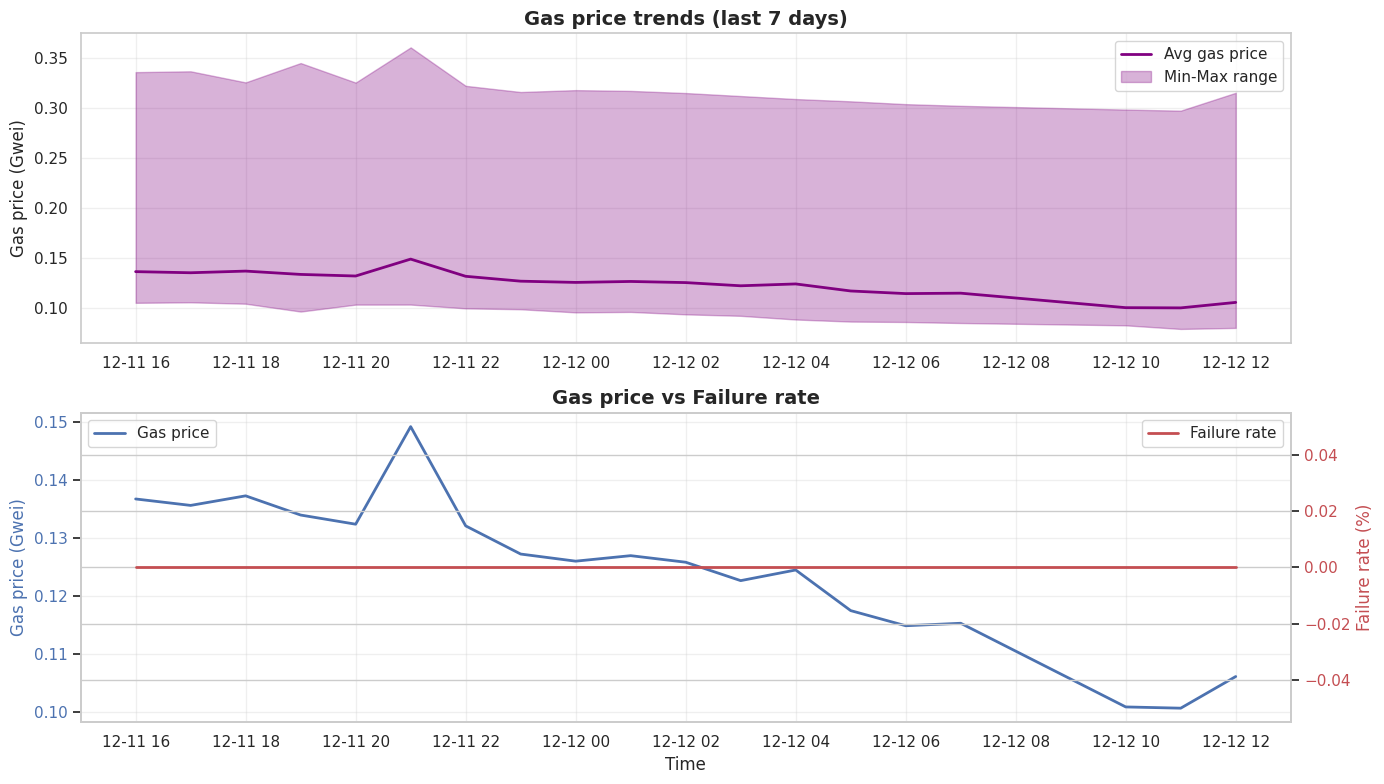


📊 Correlation between gas price and failure rate: nan


In [27]:
# Gas price тренды
gas_analysis = read_sql("""
    SELECT
        DATE_TRUNC('hour', timestamp) as hour,
        AVG(gas_price) / 1e9 as avg_gas_gwei,
        MIN(gas_price) / 1e9 as min_gas_gwei,
        MAX(gas_price) / 1e9 as max_gas_gwei,
        AVG(gas_used) as avg_gas_used,
        SUM(CASE WHEN is_error = true THEN 1 ELSE 0 END)::float / COUNT(*) * 100 as failure_rate
    FROM public.transactions
    WHERE timestamp >= NOW() - INTERVAL '7 days'
    GROUP BY DATE_TRUNC('hour', timestamp)
    ORDER BY hour
""")

gas_analysis['hour'] = pd.to_datetime(gas_analysis['hour'])

fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# Gas price over time
ax[0].plot(gas_analysis['hour'], gas_analysis['avg_gas_gwei'],
           color='purple', linewidth=2, label='Avg gas price')
ax[0].fill_between(gas_analysis['hour'],
                    gas_analysis['min_gas_gwei'],
                    gas_analysis['max_gas_gwei'],
                    alpha=0.3, color='purple', label='Min-Max range')
ax[0].set_title('Gas price trends (last 7 days)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Gas price (Gwei)', fontsize=12)
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Gas price vs failure rate
ax2 = ax[1].twinx()
ax[1].plot(gas_analysis['hour'], gas_analysis['avg_gas_gwei'],
           'b-', linewidth=2, label='Gas price')
ax2.plot(gas_analysis['hour'], gas_analysis['failure_rate'],
         'r-', linewidth=2, label='Failure rate')
ax[1].set_title('Gas price vs Failure rate', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time', fontsize=12)
ax[1].set_ylabel('Gas price (Gwei)', color='b', fontsize=12)
ax2.set_ylabel('Failure rate (%)', color='r', fontsize=12)
ax[1].tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax[1].legend(loc='upper left')
ax2.legend(loc='upper right')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Корреляция
corr = gas_analysis[['avg_gas_gwei', 'failure_rate']].corr().iloc[0, 1]
print(f"\n📊 Correlation between gas price and failure rate: {corr:.3f}")

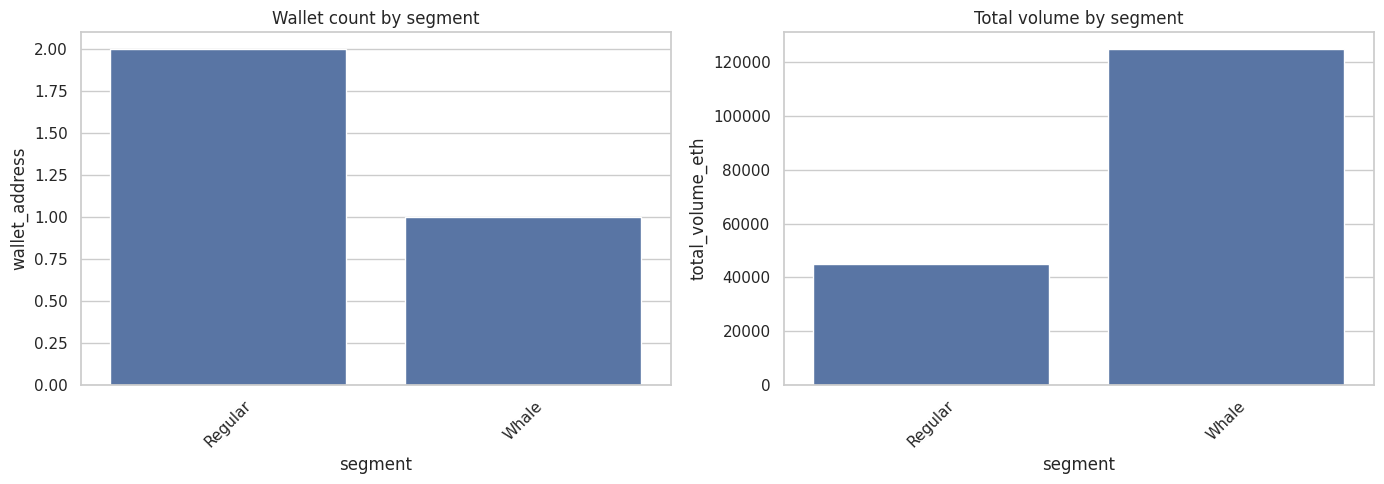

In [14]:
# Классификация по активности и объему
def segment_wallet(row):
    if row['total_volume_eth'] > wallets['total_volume_eth'].quantile(0.9):
        return 'Whale'
    elif row['actual_tx_count'] > wallets['actual_tx_count'].quantile(0.75):
        return 'Active trader'
    elif row['actual_tx_count'] == 0:
        return 'Inactive'
    else:
        return 'Regular'

wallets['segment'] = wallets.apply(segment_wallet, axis=1)

# Визуализация сегментов
segment_stats = wallets.groupby('segment').agg({
    'wallet_address': 'count',
    'total_volume_eth': 'sum',
    'net_balance_eth': 'mean'
}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=segment_stats, x='segment', y='wallet_address', ax=ax[0])
ax[0].set_title('Wallet count by segment')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(data=segment_stats, x='segment', y='total_volume_eth', ax=ax[1])
ax[1].set_title('Total volume by segment')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

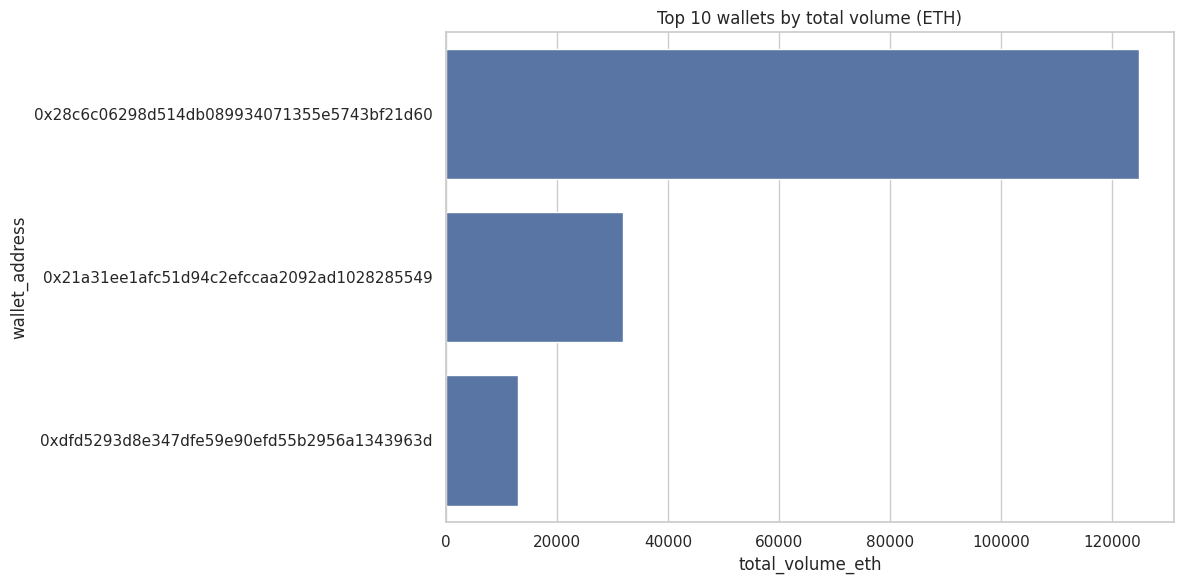

In [9]:
# --- Wallet leaderboard ---
wallets = read_sql(
    f"""
    select
        wallet_address,
        actual_tx_count,
        total_volume_eth,
        net_balance_eth,
        first_transaction_at,
        last_transaction_at,
        is_active
    from {WALLET_FACT_TBL}
    """
)

wallets["first_transaction_at"] = pd.to_datetime(wallets["first_transaction_at"], errors="coerce")
wallets["last_transaction_at"] = pd.to_datetime(wallets["last_transaction_at"], errors="coerce")

wallets = wallets.fillna({"total_volume_eth": 0, "actual_tx_count": 0, "net_balance_eth": 0})

top_n = 10
leader = wallets.sort_values("total_volume_eth", ascending=False).head(top_n)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(data=leader, x="total_volume_eth", y="wallet_address", ax=ax)
ax.set_title(f"Top {top_n} wallets by total volume (ETH)")
ax.set_xlabel("total_volume_eth")
ax.set_ylabel("wallet_address")
plt.tight_layout()
plt.show()

# concentration metric: share of volume accounted by top N
if wallets["total_volume_eth"].sum() > 0:
    share_top_n = leader["total_volume_eth"].sum() / wallets["total_volume_eth"].sum()
    {"top_n": top_n, "top_n_volume_share": float(share_top_n)}
